In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from centrex_trajectories.data_structures import Acceleration
from centrex_trajectories import propagate_trajectories
from centrex_trajectories.beamline_objects import Bore, LinearSection, ElectrostaticQuadrupoleLens
from centrex_trajectories.particles import TlF
from centrex_trajectories.random_generation import (
    generate_random_coordinates_normal_circle,
    generate_random_velocities_normal,
)

from centrex_tlf import states, hamiltonian
from centrex_trajectories.utils import fit_stark_potential

plt.rcParams.update({"font.size": 14})


In [2]:
in_to_m = 25.4e-3
R = 1.75 * in_to_m / 2
n_trajectories = 50
particle = TlF()

lens_length = 2.0


# Generate Stark Shift

In [3]:
# generate states up to J=9
QN = states.generate_uncoupled_states_ground(Js=np.arange(8))

# generate the X hamiltonian terms
H = hamiltonian.generate_uncoupled_hamiltonian_X(QN)

# create a function outputting the hamiltonian as a function of E and B
Hfunc = hamiltonian.generate_uncoupled_hamiltonian_X_function(H)

# V/cm
Ez = np.linspace(0, 50e3, 101)

# generate the Hamiltonian for (almost) zero field, add a small field to make states
# non-degenerate
Hi = Hfunc(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# get the true superposition-states of the system
QN_states = hamiltonian.matrix_to_states(V, QN)

# original eigenvectors used in tracking states as energies change order
V_track = V.copy()

# indices of the J=2, mJ=0 states focused by the lens
indices_J2_mJ0 = [
    idx for idx, s in enumerate(QN_states) if s.largest.J == 2 and s.largest.mJ == 0
]

indices_J012 = [idx for idx, s in enumerate(QN_states) if s.largest.J in [0, 1, 2]]

# empty array for storing energies
energies = np.empty([Ez.size, len(QN)], dtype=np.complex128)

# iterate over the electric field values
for idx, Ei in enumerate(Ez):
    Hi = Hfunc(E=[0, 0, Ei], B=[0, 0, 1e-3])
    E, V = np.linalg.eigh(Hi)

    # sort indices to keep the state order the same
    indices = np.argmax(np.abs(V_track.conj().T @ V), axis=1)
    energies[idx, :] = E[indices]
    V_track[:, :] = V[:, indices]

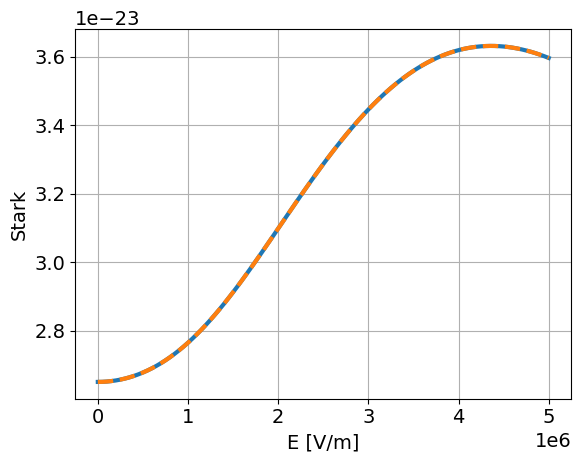

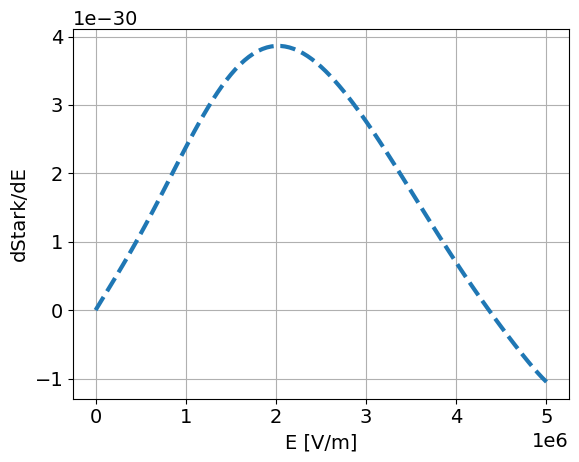

In [4]:
# convert to V/m
Ez_Vm = Ez * 100

# grab energy of J=2, mJ=0
energy = energies.real[:, indices_J2_mJ0[0]] * sp.constants.hbar

fit_coeff = fit_stark_potential(Ez_Vm, energy, deg=11)
fit = np.polynomial.Polynomial(coef=fit_coeff)

fig, ax = plt.subplots()
ax.plot(Ez_Vm, energy, lw=3)
ax.plot(Ez_Vm, fit(Ez_Vm), ls="--", lw=3)
ax.set_xlabel("E [V/m]")
ax.set_ylabel("Stark")
ax.grid(True)

fig, ax = plt.subplots()
# ax.plot(Ez_Vm, np.diff(energy) / np.diff(Ez_Vm), lw=3)
ax.plot(Ez_Vm, fit.deriv()(Ez_Vm), ls="--", lw=3)
ax.set_xlabel("E [V/m]")
ax.set_ylabel("dStark/dE")
ax.grid(True)

In [5]:
lens = ElectrostaticQuadrupoleLens(
    name="Lens",
    objects=[],
    start=0.1,
    stop=0.1 + lens_length,
    V=30_000,
    R=R,
    stark_potential=fit_coeff,
)

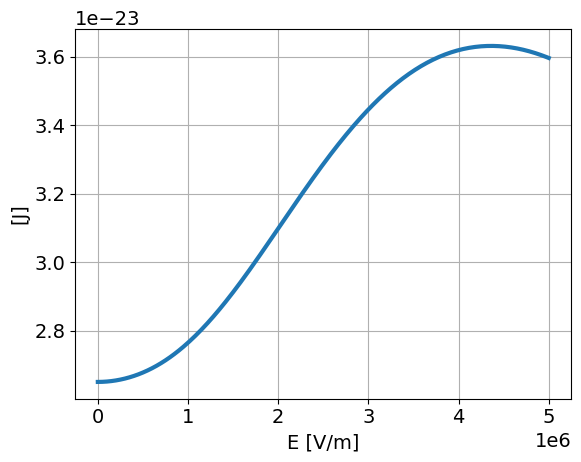

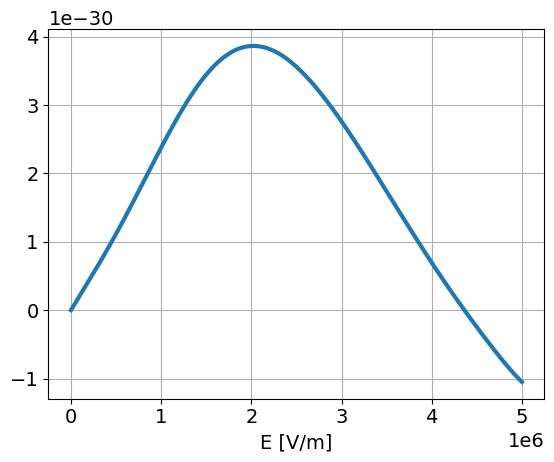

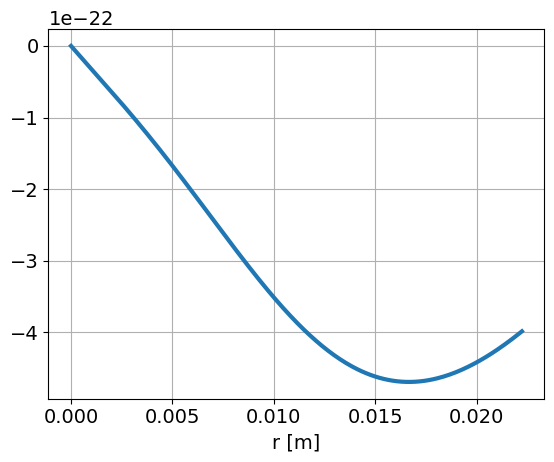

In [6]:
x = np.linspace(0, 5e6, 301)

fig, ax = plt.subplots()
ax.plot(x, lens.stark_potential_E(x), lw=3)
ax.set_xlabel("E [V/m]")
ax.set_ylabel("[J]")
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(x, lens.stark_potential_E_derivative(x), lw=3)
ax.set_xlabel("E [V/m]")
ax.grid(True)

r = np.linspace(0, R, x.size)
force = np.array([lens.force(0.0, ri, 0.0, 0.0)[0] for ri in r])
fig, ax = plt.subplots()
ax.plot(r, force, lw=3)
ax.set_xlabel("r [m]")
ax.set_ylabel("")
ax.grid(True)

In [7]:
k = abs(float(force[len(force)//2] / r[len(force)//2]))
k

3.472848959621723e-20

In [8]:
coords = generate_random_coordinates_normal_circle(2e-3, n_trajectories)

velocities = generate_random_velocities_normal(
    vx=0.0,
    vy=0.0,
    vz=184.0,
    sigma_vx=4.0,
    sigma_vy=4.0,
    sigma_vz=16.5,
    number=n_trajectories,
)


In [9]:
bore = Bore(x=0.0, y=0.0, z = 0.1, length = lens_length, radius=R)
eql_analytical = LinearSection(
    name="EQL",
    objects=[bore],
    start = 0.1,
    stop = 0.1 + lens_length,
    save_collisions=False,
    spring_constant=(k, k, 0.0)
)
lens = ElectrostaticQuadrupoleLens(
    name="Lens",
    objects=[bore],
    start=0.1,
    stop=0.1 + lens_length,
    V=30_000,
    R=R,
    stark_potential=fit_coeff,
    save_collisions=True
)

lens_nb = ElectrostaticQuadrupoleLens(
    name="Lens",
    objects=[],
    start=0.1,
    stop=0.1 + lens_length,
    V=30_000,
    R=R,
    stark_potential=fit_coeff,
    save_collisions=True
)

sections = [eql_analytical]
sections_ode = [lens]
sections_nb = [lens_nb]

In [10]:
section_data, trajectories = propagate_trajectories(
    sections, coords, velocities, particle, z_save = np.linspace(0.1, 0.1 + lens_length, 101)
)

section_data_ode, trajectories_ode = propagate_trajectories(
    sections_ode, coords, velocities, particle
)

section_data_ode_nb, trajectories_ode_nb = propagate_trajectories(
    sections_nb, coords, velocities, particle
)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


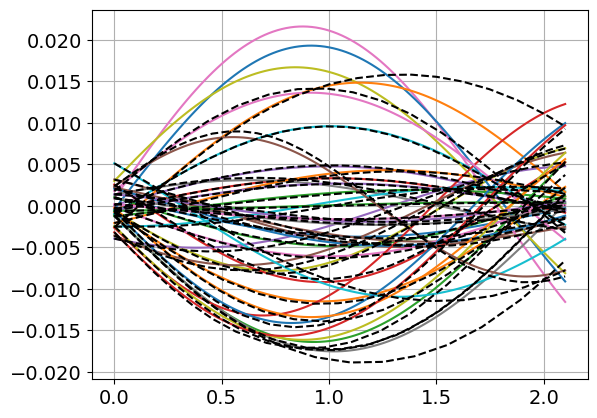

In [11]:
fig, ax = plt.subplots()

for traj in trajectories.values():
    ax.plot(traj.z, traj.y)

for traj in trajectories_ode.values():
    ax.plot(traj.z, traj.y, ls = '--', color = 'k')


# for traj in trajectories_ode_nb.values():
#     ax.plot(traj.z, traj.y, ls = '--', color = 'k')


ax.grid()

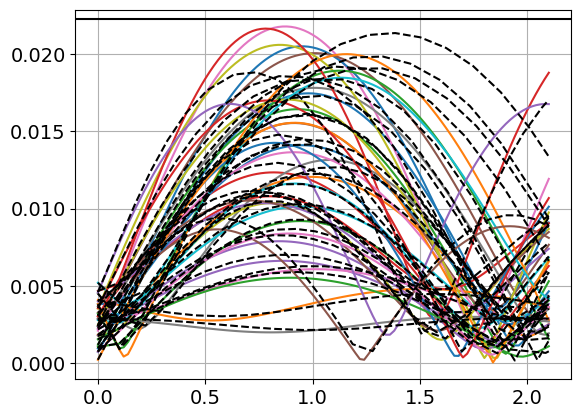

In [12]:
fig, ax = plt.subplots()

for traj in trajectories.values():
    ax.plot(traj.z, np.sqrt(traj.x**2+ traj.y**2))

for traj in trajectories_ode.values():
    ax.plot(traj.z, np.sqrt(traj.x**2 + traj.y**2), ls = '--', color = 'k')

# for traj in trajectories_ode_nb.values():
#     ax.plot(traj.z, np.sqrt(traj.x**2 + traj.y**2), ls = '--', color = 'k')

ax.axhline(R, color = 'k')
ax.grid()

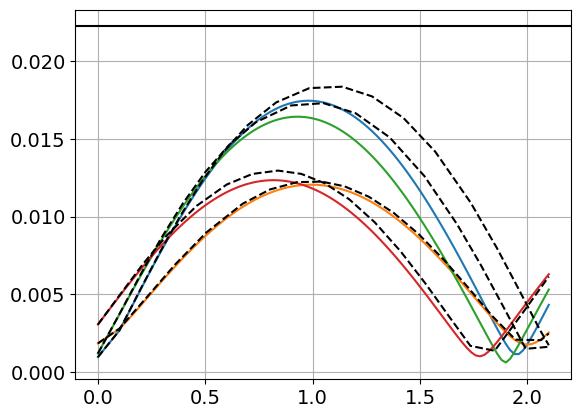

In [28]:
fig, ax = plt.subplots()

for idt, traj in enumerate(trajectories.values()):
    ax.plot(traj.z, np.sqrt(traj.x**2+ traj.y**2))
    if idt >= 3:
        break

for idt, traj in enumerate(trajectories_ode.values()):
    ax.plot(traj.z, np.sqrt(traj.x**2 + traj.y**2), ls = '--', color = 'k')
    if idt >= 3:
        break

# for traj in trajectories_ode_nb.values():
#     ax.plot(traj.z, np.sqrt(traj.x**2 + traj.y**2), ls = '--', color = 'k')

ax.axhline(R, color = 'k')
ax.grid()